In [29]:
import pandas as pd
import numpy as np
import pandas_datareader as pdr
import matplotlib.pyplot as plt
import requests 

In [30]:
import pandas_datareader as pdr
import matplotlib.pyplot as plt

btc_usd = pdr.get_data_yahoo('BTC-USD', '2-March-19') 
btc_usd.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-03-02,3874.607422,3832.127930,3855.318115,3864.415039,7.578786e+09,3864.415039
2019-03-03,3875.483643,3836.905762,3862.266113,3847.175781,7.253558e+09,3847.175781
2019-03-04,3867.381836,3733.749756,3845.091553,3761.557129,9.029176e+09,3761.557129
2019-03-05,3903.916748,3745.183105,3759.832520,3896.375000,1.017413e+10,3896.375000
2019-03-06,3919.510498,3871.460693,3897.081055,3903.942627,9.175292e+09,3903.942627


In [31]:
btc_usd['9_SMA'] = btc_usd['Close'].rolling(window=9).mean()
btc_usd['50_SMA'] = btc_usd['Close'].rolling(window=50).mean()

btc_usd = btc_usd[btc_usd['50_SMA'].notna()]

# SMA trade signals
Trade_Buy=[]
Trade_Sell=[]
for i in range(len(btc_usd)-1):
    if ((btc_usd['9_SMA'].values[i] < btc_usd['50_SMA'].values[i]) & (btc_usd['9_SMA'].values[i+1] >btc_usd['50_SMA'].values[i+1])):
        print("Trade Signal for {row} is Buy.".format(row=btc_usd.index[i].date()))
        Trade_Buy.append(i)
    elif ((btc_usd['9_SMA'].values[i] > btc_usd['50_SMA'].values[i]) & (btc_usd['9_SMA'].values[i+1] < btc_usd['50_SMA'].values[i+1])):
        print("Trade Signal for {row} is Sell.".format(row=btc_usd.index[i].date()))
        Trade_Sell.append(i)

Trade Signal for 2019-07-22 is Sell.
Trade Signal for 2019-08-05 is Buy.
Trade Signal for 2019-08-16 is Sell.
Trade Signal for 2019-09-08 is Buy.
Trade Signal for 2019-09-09 is Sell.
Trade Signal for 2019-10-30 is Buy.
Trade Signal for 2019-11-18 is Sell.
Trade Signal for 2020-01-06 is Buy.
Trade Signal for 2020-02-28 is Sell.
Trade Signal for 2020-04-16 is Buy.
Trade Signal for 2020-06-19 is Sell.
Trade Signal for 2020-06-20 is Buy.
Trade Signal for 2020-06-22 is Sell.


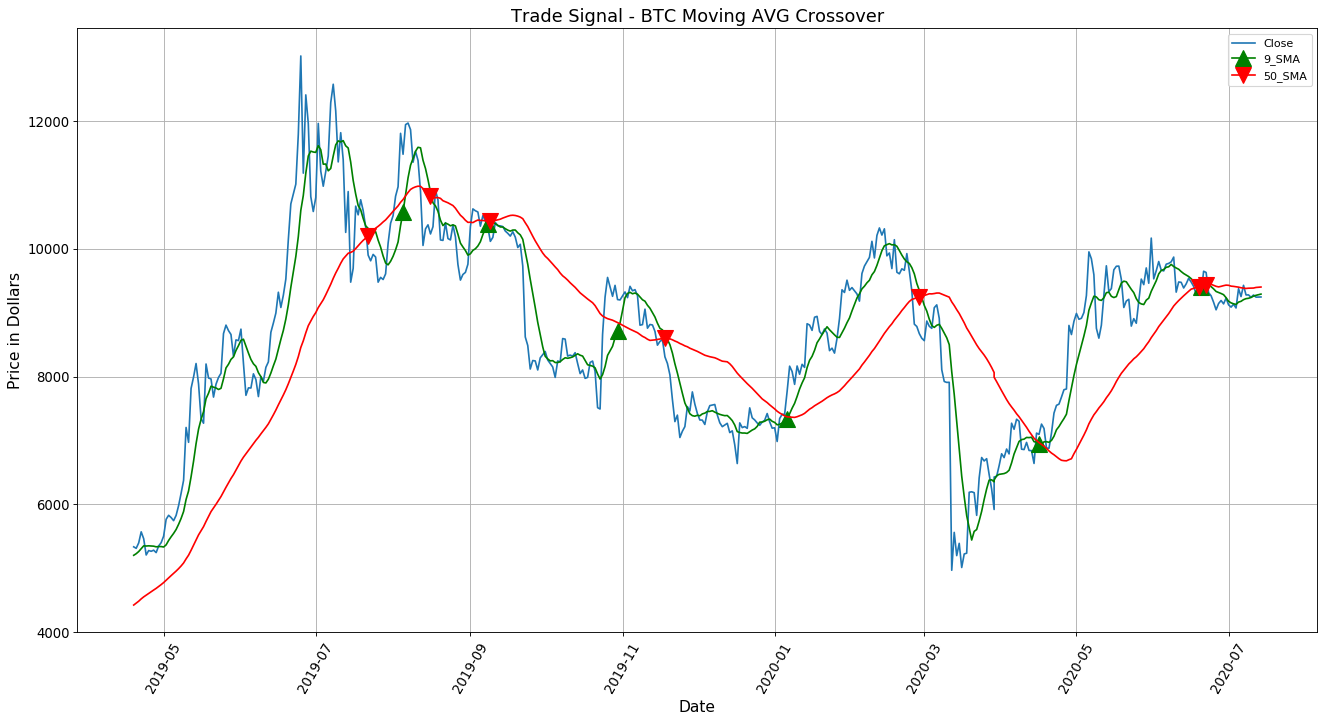

In [33]:
plt.figure(figsize=(20, 10),dpi=80)
plt.plot(btc_usd.index, btc_usd['Close'])
plt.plot(btc_usd.index, btc_usd['9_SMA'],'-^', markevery=Trade_Buy, ms=15, color='green')
plt.plot(btc_usd.index, btc_usd['50_SMA'],'-v', markevery=Trade_Sell, ms=15, color='red')
plt.xlabel('Date',fontsize=14)
plt.ylabel('Price in Dollars', fontsize = 14)
plt.xticks(rotation='60',fontsize=12)
plt.yticks(fontsize=12)
plt.title('Trade Signal - BTC Moving AVG Crossover', fontsize = 16)
plt.legend(['Close','9_SMA','50_SMA'])
plt.grid()
plt.show() 

In [13]:
# Define API
url = 'https://newsapi.org/v2/everything?'

# number of returns
parameters = {
    'q': 'Bitcoin', # query phrase
    'sortBy': 'popularity', # articles from popular sources and publishers come first
    'pageSize': 100,  # maximum is 100 for developer version
    'apiKey': '41f82539f4ec4ba79932a9ce234f115a', # your own API key
}

# Make the request
response = requests.get(url, params=parameters)

# Convert the response to JSON format and store it in dataframe
data = pd.DataFrame(response.json())

article_df = pd.concat([data['articles'].apply(pd.Series)], axis=1)

news_article = article_df.loc[:,['publishedAt','title']]
news_article['publishedAt'] = pd.to_datetime(news_article['publishedAt'])
news_article.sort_values(by='publishedAt',inplace=True)

# Import BDay to determine business day's dates
from pandas.tseries.offsets import BDay
# to get the business day for which particular news headline should be used to make trade signal
def get_trade_open(date):
    curr_date_open = pd.to_datetime(date).floor('d').replace(hour=13,minute=30) - BDay(0)
    curr_date_close = pd.to_datetime(date).floor('d').replace(hour=20,minute=0) - BDay(0)
    
    prev_date_close = (curr_date_open - BDay()).replace(hour=20,minute=0)
    next_date_open = (curr_date_close + BDay()).replace(hour=13,minute=30)
    
    if ((pd.to_datetime(date)>=prev_date_close) & (pd.to_datetime(date)<curr_date_open)):
        return curr_date_open
    elif ((pd.to_datetime(date)>=curr_date_close) & (pd.to_datetime(date)<next_date_open)):
        return next_date_open
    else:
        return None
      
 # Apply the above function to get the trading time for each news headline
news_article["trading_time"] = news_article["publishedAt"].apply(get_trade_open)

news_article = news_article[pd.notnull(news_article['trading_time'])]
news_article['Date'] = pd.to_datetime(pd.to_datetime(news_article['trading_time']).dt.date)

In [14]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Kevin\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [15]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

In [16]:
cs = []
for row in range(len(news_article)):
    cs.append(analyzer.polarity_scores(news_article['title'].iloc[row])['compound'])

news_article['compound_vader_score'] = cs
news_article = news_article[(news_article[['compound_vader_score']] != 0).all(axis=1)].reset_index(drop=True)

news_article.tail()

,publishedAt,title,trading_time,Date,compound_vader_score
17,2020-07-02 13:29:22+00:00,Three major Bitcoin wallet apps found vulnerab...,2020-07-02 13:30:00+00:00,2020-07-02,-0.6908
18,2020-07-04 10:01:38+00:00,Los mejores cursos gratis online de las diez m...,2020-07-06 13:30:00+00:00,2020-07-06,0.0516
19,2020-07-05 04:00:00+00:00,Gain access to thousands of online courses for...,2020-07-06 13:30:00+00:00,2020-07-06,0.5267
20,2020-07-06 10:34:00+00:00,Venture Capitalists' Critiques of Journalism S...,2020-07-06 13:30:00+00:00,2020-07-06,-0.3182
21,2020-07-08 08:43:52+00:00,Building a programming language? It’s pretty m...,2020-07-08 13:30:00+00:00,2020-07-08,0.6124


In [17]:
unique_dates = news_article['Date'].unique()
grouped_dates = news_article.groupby(['Date'])
keys_dates = list(grouped_dates.groups.keys())

max_cs = []
min_cs = []

for key in grouped_dates.groups.keys():
    data = grouped_dates.get_group(key)
    if data["compound_vader_score"].max() > 0:
        max_cs.append(data["compound_vader_score"].max())
    elif data["compound_vader_score"].max() < 0:
        max_cs.append(0)
    
    if data["compound_vader_score"].min() < 0:
        min_cs.append(data["compound_vader_score"].min())
    elif data["compound_vader_score"].min() > 0:
        min_cs.append(0)
    
vader_scores_dict = {'Date':keys_dates,'max_scores':max_cs,'min_scores':min_cs}
vader_scores_df = pd.DataFrame(vader_scores_dict)

In [18]:
final_scores = []
for i in range(len(vader_scores_df)):
    final_scores.append(vader_scores_df['max_scores'].values[i] + vader_scores_df['min_scores'].values[i])

vader_scores_df['final_scores'] = final_scores

vader_scores_df.head()

,Date,max_scores,min_scores,final_scores
0,2020-06-10,0.7003,0.0000,0.7003
1,2020-06-11,0.0000,-0.3400,-0.3400
2,2020-06-12,0.7430,-0.5859,0.1571
3,2020-06-18,0.3818,-0.4588,-0.0770
4,2020-06-22,0.6597,-0.3089,0.3508


In [19]:
# VADER trade Signal - with threshold
vader_Buy=[]
vader_Sell=[]
for i in range(len(vader_scores_df)):
    if vader_scores_df['final_scores'].values[i] > 0.20:
        print("Trade Signal for {row} is Buy.".format(row=vader_scores_df['Date'].iloc[i].date()))
        vader_Buy.append(vader_scores_df['Date'].iloc[i].date())
    elif vader_scores_df['final_scores'].values[i] < -0.20:
        print("Trade Signal for {row} is Sell.".format(row=vader_scores_df['Date'].iloc[i].date()))
        vader_Sell.append(vader_scores_df['Date'].iloc[i].date())

Trade Signal for 2020-06-10 is Buy.
Trade Signal for 2020-06-11 is Sell.
Trade Signal for 2020-06-22 is Buy.
Trade Signal for 2020-06-26 is Sell.
Trade Signal for 2020-07-02 is Sell.
Trade Signal for 2020-07-06 is Buy.
Trade Signal for 2020-07-08 is Buy.


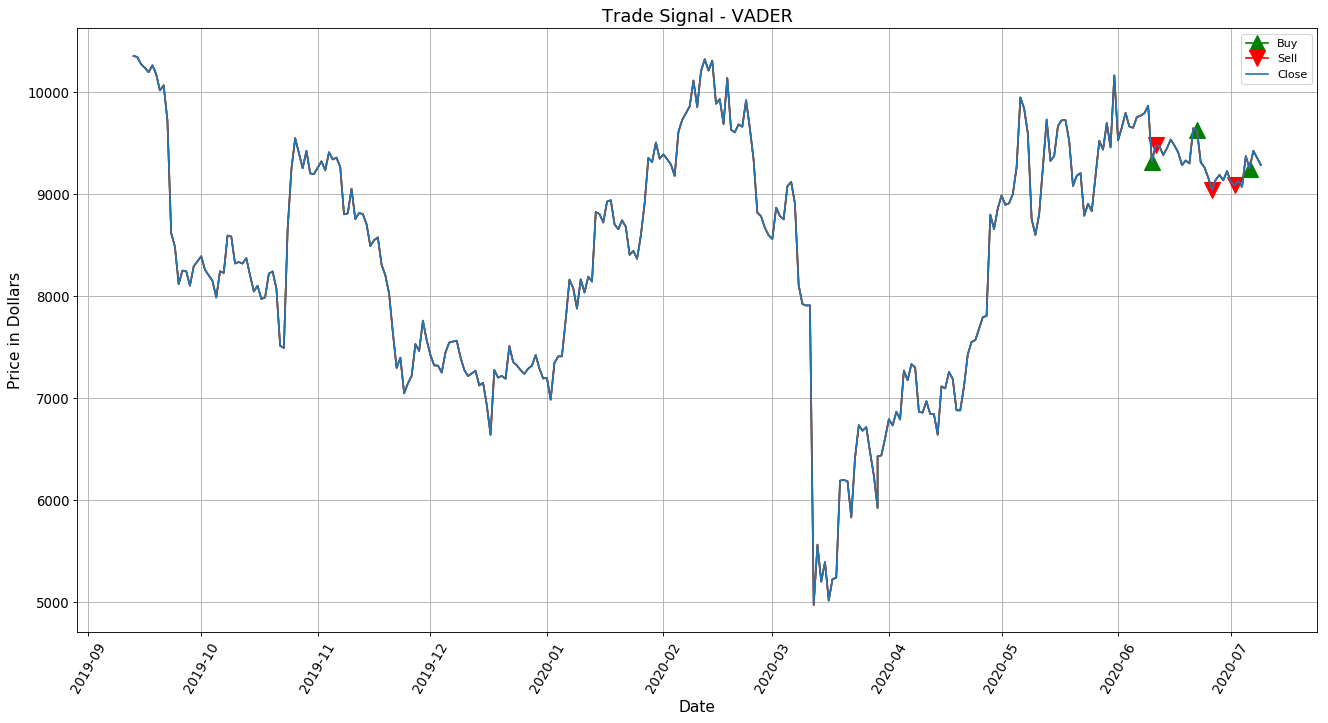

In [24]:
vader_buy = []
for i in range(len(btc_usd)):
    if btc_usd.index[i].date() in vader_Buy:
        vader_buy.append(i)
        
vader_sell = []
for i in range(len(btc_usd)):
    if btc_usd.index[i].date() in vader_Sell:
        vader_sell.append(i)
        
plt.figure(figsize=(20, 10),dpi=80)
plt.plot(btc_usd.index, btc_usd['Close'],'-^', markevery=vader_buy, ms=15, color='green')
plt.plot(btc_usd.index, btc_usd['Close'],'-v', markevery=vader_sell, ms=15, color='red')
plt.plot(btc_usd.index, btc_usd['Close'])
plt.xlabel('Date',fontsize=14)
plt.ylabel('Price in Dollars', fontsize = 14)
plt.xticks(rotation='60',fontsize=12)
plt.yticks(fontsize=12)
plt.title('Trade Signal - VADER', fontsize = 16)
plt.legend(['Buy','Sell','Close'])
plt.grid()
plt.show()

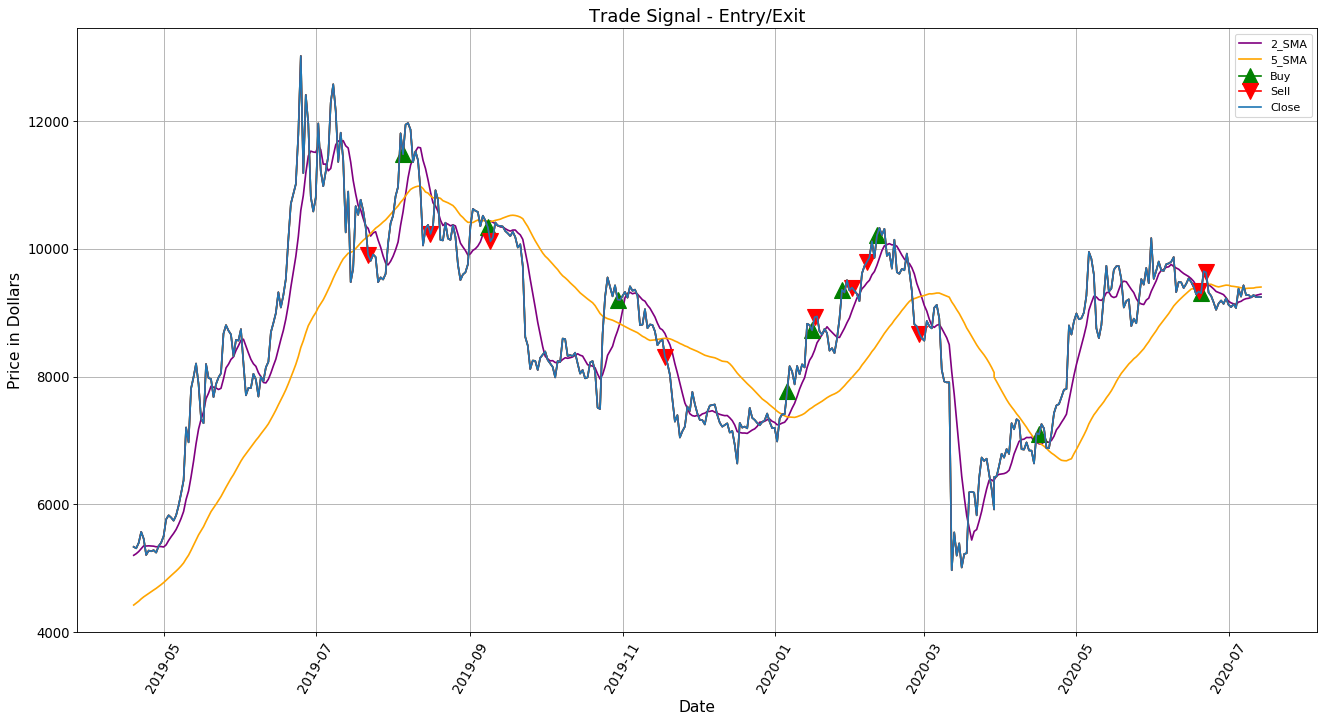

In [32]:
#prioritising SMA signals
final_buy = list(set(Trade_Buy + vader_buy) - set(Trade_Sell)) 
final_sell = list(set(Trade_Sell + vader_sell) - set(Trade_Buy))

plt.figure(figsize=(20, 10),dpi=80)
plt.plot(btc_usd.index, btc_usd['9_SMA'], color='purple')
plt.plot(btc_usd.index, btc_usd['50_SMA'], color='orange')
plt.plot(btc_usd.index, btc_usd['Close'],'-^', markevery=final_buy, ms=15, color='green')
plt.plot(btc_usd.index, btc_usd['Close'],'-v', markevery=final_sell, ms=15, color='red')
plt.plot(btc_usd.index, btc_usd['Close'])
plt.xlabel('Date',fontsize=14)
plt.ylabel('Price in Dollars', fontsize = 14)
plt.xticks(rotation='60',fontsize=12)
plt.yticks(fontsize=12)
plt.title('Trade Signal - Entry/Exit', fontsize = 16)
plt.legend(['2_SMA','5_SMA','Buy','Sell','Close'])
plt.grid()
plt.show()